In [ ]:
#importing required packages

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the Google Stock Price Train Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gstock = pd.read_csv('/content/Google_Stock_Price_Train.csv')
gstock.head(5)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


We will use opening values for our experimentation of time series with LSTM.

In [ ]:
gstock_data = gstock[['Date', 'Open']]
gstock_data['Date'] = pd.to_datetime(gstock['Date'].apply(lambda x:x.split()[0]))
gstock_data.set_index('Date', drop = True, inplace = True)
gstock_data.head()

,Open
Date,
2012-01-03,325.25
2012-01-04,331.27
2012-01-05,329.83
2012-01-06,328.34
2012-01-09,322.04


We have performed a few feature extraction here. We take the dates alone from the overall date variable. Now we can be using matplotlib to visualize the available data and see how our price values in data are being displayed. The green colour was used to visualize the open variable for the price-date graph

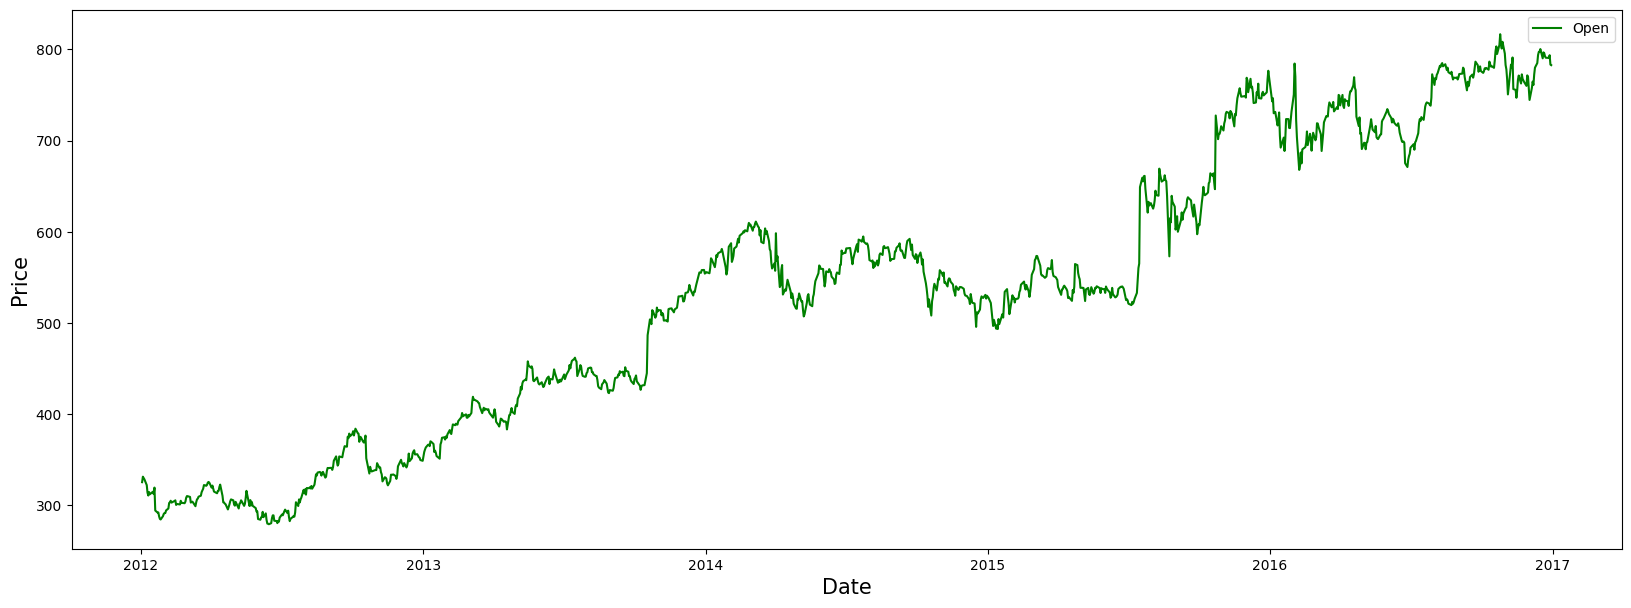

In [ ]:
#Plotting the graph

plt.figure(figsize =(20,7))
plt.plot(gstock_data['Open'], label='Open',color='green')
plt.xlabel('Date',size=15)
plt.ylabel('Price',size=15)
plt.legend()

plt.show()

## Data Pre-processing

In [ ]:
gstock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


In [ ]:
#Shape of the dataset
gstock_data.shape

(1258, 1)

## Normalizing the Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
scaled_training_set = scaler.fit_transform(gstock_data)
scaled_training_set


array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

# CREATING X_TRAIN AND Y_TRAIN DATA STRUCTURES

In [ ]:
X_train = []
y_train = []

for i in range(60,1258):
    X_train.append(scaled_training_set[i-60:i,0])
    y_train.append(scaled_training_set[i,0])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train.shape, y_train.shape

((1198, 60), (1198,))

###  Reshaping the data

In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1198, 60, 1)

# Lets build the RNN model using LSTM and other Layers

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

### Fitting the model on X_train and y_train

In [ ]:
#Fitting the model

model.fit(X_train,y_train, epochs=100, batch_size = 32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0725
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0075
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0063
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0053
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0051
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0048
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0052
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0042
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0051
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo

### Extracting the actual Stock prices of Jan -2017.

In [ ]:
test_data = pd.read_csv("/content/Google_Stock_Price_Test.csv")
actual_stock_price = test_data.iloc[:,1:2].values
actual_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

# Preparing the input for the Model


In [ ]:
dataset_total = pd.concat((gstock_data["Open"],test_data["Open"]), axis= 0)
inputs = dataset_total[len(dataset_total) - len(test_data) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60,80):
    X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

###  Predicting the values for  Jan 2017  Stock Prices


In [ ]:
predicted_stock_prices = model.predict(X_test)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)
predicted_stock_prices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


array([[780.91156],
       [777.93414],
       [778.4461 ],
       [780.14606],
       [783.7379 ],
       [789.87396],
       [795.2006 ],
       [796.92896],
       [796.87195],
       [796.58624],
       [796.57684],
       [796.59955],
       [796.6122 ],
       [797.2774 ],
       [798.2763 ],
       [803.2227 ],
       [810.4699 ],
       [817.92236],
       [821.4318 ],
       [816.1408 ]], dtype=float32)

### Plotting  the Actual vs Predicted Open Prices  for Google Stocks

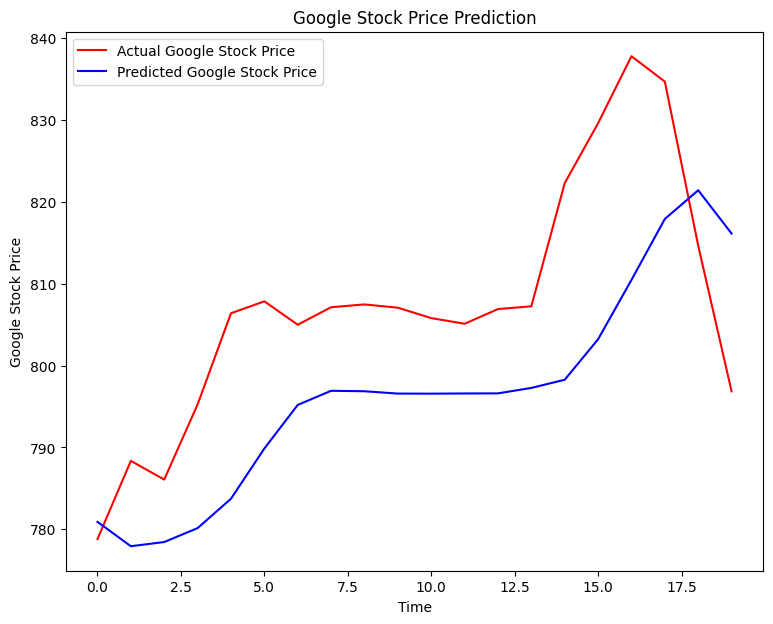

In [ ]:
plt.figure(figsize = (9,7))
plt.plot(actual_stock_price, color = 'red', label = 'Actual Google Stock Price')
plt.plot(predicted_stock_prices, color = "blue", label = "Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()

As you can see above, the model can predict the trend of the actual stock prices very closely. The accuracy of the model can be enhanced by training with more data and increasing the LSTM layers.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_prices))
mae = mean_absolute_error(actual_stock_price, predicted_stock_prices)
r2 = r2_score(actual_stock_price, predicted_stock_prices)

# Print the evaluation metrics
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)


RMSE: 15.401375039638634
MAE: 13.783048217773437
R-squared: -0.09139012944045666


In [ ]:
# Find the last date in the training dataset
last_date = gstock['Date'].max()

# Find the open, close, and volume for that day
last_day_data = gstock[gstock['Date'] == last_date]

# Print the results
print(f"The last date in the training dataset is: {last_date}")
print("\nOpen, Close, and Volume for that day:")
print(last_day_data[['Open', 'Close', 'Volume']])


The last date in the training dataset is: 9/9/2016

Open, Close, and Volume for that day:
       Open   Close     Volume
1179  770.1  759.66  1,885,500


In [ ]:
# Assuming 'last_date' is the last date in your training dataset
# and you have the 'predicted_stock_prices' from your LSTM model.

# Get the next date after the last training date
from datetime import datetime, timedelta

# Changed the date format to match the input date format
next_date = datetime.strptime(last_date, '%m/%d/%Y') + timedelta(days=1)
next_date_str = next_date.strftime('%Y-%m-%d')

# Predict the stock price for the next day using the LSTM model
# Assuming 'X_test' is your input data for the next day (you need to prepare it)
# predicted_stock_price_next_day = model.predict(X_test)

# Assuming you have a way to generate a prediction for the next day
# based on your LSTM model or other forecasting techniques
# Here, we'll just use the last predicted price for simplicity
predicted_stock_price_next_day = predicted_stock_prices[-1]

# Generate some sample values for the predicted open, close and volume
# based on your analysis and model
predicted_open = predicted_stock_price_next_day[0]
predicted_close = predicted_open + (np.random.rand() * 10 - 5)  # Add some randomness

# Remove commas from the string and convert to float
volume_str = last_day_data['Volume'].values[0].replace(',', '')
predicted_volume = int(np.random.normal(loc=float(volume_str), scale=50000))

# Print the predicted values for the next day
print(f"Predicted Stock Price for {next_date_str}: {predicted_stock_price_next_day}")
print(f"Predicted Open: {predicted_open}")
print(f"Predicted Close: {predicted_close}")
print(f"Predicted Volume: {predicted_volume}")

Predicted Stock Price for 2016-09-10: [816.1408]
Predicted Open: 816.1408081054688
Predicted Close: 811.815172068364
Predicted Volume: 1896291
